## Skin cancer CNN

Los datos para la resolución de este problema pueden encontrarse en https://www.kaggle.com/datasets/rm1000/skin-cancer-isic-images?select=malignant

---

#### Definición del problema

El objetivo de este problema es crear un modelo de clasificación de imágenes mediante el uso de redes neuronales convolucionales. La base de datos está formada por 2 carpetas de imágenes de 224x224 de manchas cutáneas de diferentes pacientes, donde las imágenes de cada carpeta comparten una misma clase o eqtiqueta. Estas pueden ser: benign o malignant. Dado que solo existen 2 posibles clases, podemos definir este problema como uno de clasificación binaria. 

En primer lugar, importamos todas y cada una de las librerías y módulos que se utilizarán durante la creación del modelo.

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import time

import torch
import torch.nn as nn
import numpy as np
import skimage.io
import skimage.segmentation
import skimage.transform
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import models

---

## Cargar la base de datos y preprocesamiento
A continuación, se cargan las imágenes utilizando el directorio de la carpeta en la que se encuentran. A partir de él, se generan 2 datasets aplicando un conjunto de transformaciones a cada uno de ellos. 

1. **Definición de directorio de datos**:
   - La variable `data_dir` contiene la ruta al directorio donde se encuentran las imágenes del dataset. En este caso, las imágenes están en `C:\Users\Usuario\Desktop\Trabajo Fin de Grado\skin_cancer`, que tiene subcarpetas para las clases (por ejemplo, "benign" y "malignant").

2. **Transformaciones de preprocesamiento**:
   - Se definen dos tipos de transformaciones para las imágenes antes de pasarlas al modelo. Las transformaciones se aplican utilizando `transforms.Compose()`, que permite encadenar varias transformaciones secuenciales.

   - **`transform_no_norm`**: 
     - Primero, las imágenes se redimensionan a 128x128 píxeles con `transforms.Resize((128, 128))`.
     - Luego, se convierten a un tensor con `transforms.ToTensor()`, lo que cambia las imágenes de formato de PIL o numpy a tensores PyTorch.
     - En este caso, no se aplica normalización a las imágenes.

   - **`transform_norm`**:
     - Al igual que el primero, las imágenes se redimensionan a 128x128 píxeles con `transforms.Resize((128, 128))`.
     - Luego se convierten en tensores con `transforms.ToTensor()`.
     - A diferencia de `transform_no_norm`, se aplica una normalización con `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`. Estos valores corresponden a las medias y desviaciones estándar utilizadas comúnmente para modelos preentrenados (como AlexNet y ResNet) que fueron entrenados en el conjunto de datos ImageNet.

3. **Carga del dataset**:
   - Se utilizan dos instancias de `datasets.ImageFolder` para cargar las imágenes desde el directorio `data_dir`. 
   
   - **`dataset_no_norm`**:
     - Carga las imágenes aplicando la transformación definida por `transform_no_norm` (sin normalización).

   - **`dataset_norm`**:
     - Carga las imágenes aplicando la transformación definida por `transform_norm` (con normalización).

In [121]:
data_dir = r'C:\Users\Usuario\Desktop\Trabajo Fin de Grado\skin_cancer'

transform_no_norm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

transform_norm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_no_norm = datasets.ImageFolder(root=data_dir, transform=transform_no_norm)
dataset_norm = datasets.ImageFolder(root=data_dir, transform=transform_norm)

---

## Visualización de datos
Una vez se tienen ambas bases de datos, se muestran por pantalla varias imágenes de cada una de las clases para, en primer lugar, visualizar cómo son algunas de las manchas que se van a clasificar y, en segundo lugar, para observar la diferencia entre las imágenes normalizadas y las que se encuentran en su estado natural. Se mostrarán 3 muestras de manchas cuya etiqueta es 'benign' y otras 3 cuya etiqueta es 'malign'. En cada par, la imagen situada a la izquierda se corresponde con la imagen en estado natural, mientras que a la derecha se coloca esa misma imagen normalizada.

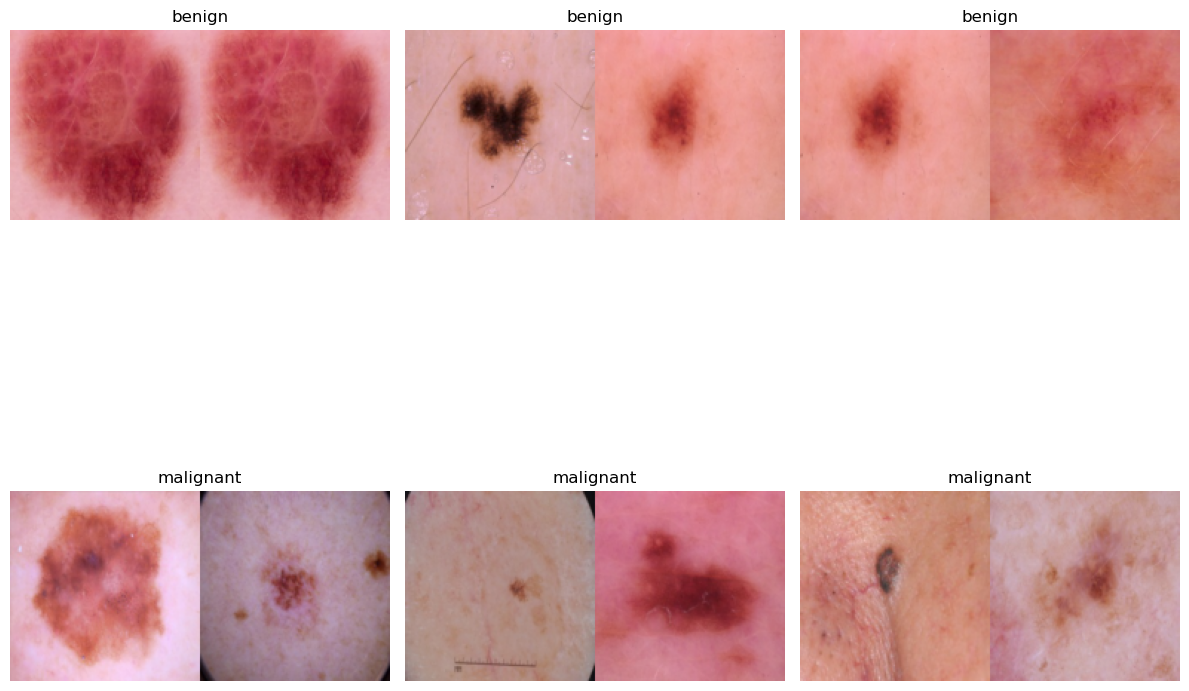

In [125]:
images = []

samples_per_class = {0: 0, 1: 0}
for img_no_norm, label in dataset_no_norm:
    if samples_per_class[label] < 3:
        img_norm, _ = dataset_norm[samples_per_class[label] + sum(samples_per_class.values())]
        images.append((img_no_norm, img_norm, dataset_no_norm.classes[label]))
        samples_per_class[label] += 1
    if len(images) == 6:
        break

fig, axes = plt.subplots(2, 3, figsize=(12, 12))
axes = axes.ravel()  

for idx, (img_no_norm, img_norm, label_name) in enumerate(images):
    img_norm = img_norm.clone()
    img_norm = img_norm * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img_norm = torch.clamp(img_norm, 0, 1) 

    combined_img = torch.cat((img_no_norm, img_norm), dim=2)  

    axes[idx].imshow(combined_img.permute(1, 2, 0).numpy())  
    axes[idx].set_title(f"{label_name}")
    axes[idx].axis('off')

for ax in axes[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

---

## Definición de arquitecturas de las CNN
El siguiente paso es definir las diferentes arquitecturas que se van a utilizar para entrenar la CNN. La primera de ellas no está previamente definida y se consigue mediante la adición de diferentes capas de convolución, completamente conectadas y dropout en busca de lograr el modelo con la mejor eficacia posible.

#### Primera capa de convolución (CONV1)
Recibe una imgen con 3 canales (RGB) y aplica 32 filtros con un kernel de 3x3. Su función de activación es ReLu y realiza un Max Pooling en una ventana de 2x2. 

#### Segunda capa de convolución (CONV2)
Recibe 32 mapas de características (uno por cada filtro aplicado en la clase anterior) y aplica 64 filtros con un kernel de 3x3. Su función de activación es ReLu y realiza un Max Pooling en una ventana de 2x2.

#### Tercera capa de convolución (CONV3)
Recibe 64 canales de entrada  y aplica 128 filtros con un kernel de 3x3. Su función de activación es ReLu y realiza un Max Pooling en una ventana de 2x2.

#### Cuarta capa de convolución (CONV4)
Recibe 128 canales de entrada  y aplica 256 filtros con un kernel de 3x3. Su función de activación es ReLu y realiza un Max Pooling en una ventana de 2x2.

#### Capa de aplanamiento (Flatten)
Una vez concluidas las capas convolucionales, se aplanan de los mapas de características obtenidos como salida de la CONV3 en un vector unidimensional. Este vector será el input de la primera capa conectada.

#### Primera capa completamente conectada (FC1)
Recibe el vector unidimensional de dimensión 256*8*8 generado anteriormente y tiene como salida un vector de 512 elementos, uno por cada neurona de la capa. Su función de activación es ReLu.

#### Primera capa de Dropout
Establece que el 30% de las neuronas de esta capa se desactivarán. El objetivo es reducir la dependencia del modelo y el sobreajuste.

#### Segunda capa completamente conectada (FC2)
Recibe un vector de 512 elementos y devuelve uno de 256. Su función de activación es ReLU.

#### Segunda capa de Dropout
Establece que el 50% de las neuronas de esta capa se desactivarán. Esta capa permite que el modelo generalice mejor los patrones aprendidos en el conjunto de test.

#### Tercera capa completamente conectada (FC3)
Recibe un vector de 256 elementos y devuelve un único elemento, que determinará la clase predicha. Aplica la función de activación softmax (adecuada para casos de clasificación múltiple), que nos aporta un grado de confianza para cada una de las clases.

In [128]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)

        # Ajusta el tamaño según el tamaño real del tensor
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x


---

## Definición de la arquitectura Le Net
La arquitectura LeNet es una red neuronal convolucional diseñada para tareas de clasificación. En esta versión, se ha adaptado para procesar imágenes de entrada de tamaño **118x118x3**. La red cuenta con capas convolucionales, de pooling y completamente conectadas para extraer características y realizar la clasificación.

#### Primera capa de convolución (CONV1)
Recibe una imagen con 3 canales (RGB) y aplica 6 filtros con un kernel de 5x5, produciendo un mapa de características de dimensiones **114x114x6**. La función de activación es ReLU, y la salida de esta capa pasa a una capa de Max Pooling con una ventana de 2x2, reduciendo las dimensiones a **57x57x6**.

#### Segunda capa de convolución (CONV2)
Recibe 6 mapas de características y aplica 16 filtros con un kernel de 5x5, produciendo un mapa de características de dimensiones **53x53x16**. La función de activación es ReLU y realiza un Max Pooling en una ventana de 2x2, reduciendo las dimensiones a **26x26x16**.

#### Capa de aplanamiento (Flatten)
Después de las capas convolucionales y de pooling, los mapas de características de salida de la segunda capa de convolución se aplanan en un vector unidimensional de **16 * 26 * 26 = 10,816** elementos. Este vector se usará como entrada en la primera capa completamente conectada.

#### Primera capa completamente conectada (FC1)
Recibe el vector de **10,816** elementos (formado por el aplanamiento de las salidas anteriores) y tiene como salida un vector de **120** elementos, donde cada elemento corresponde a una neurona de la capa. La función de activación utilizada es ReLU.

#### Segunda capa completamente conectada (FC2)
Esta capa recibe un vector de **120** elementos y produce una salida de **84** elementos. La función de activación utilizada es ReLU.

#### Tercera capa completamente conectada (FC3)
La capa final recibe un vector de **84** elementos y produce una única salida. La función de activación en esta capa es Sigmoid, lo cual es adecuado para un problema de clasificación binaria, ya que da una probabilidad para cada una de las dos clases posibles.

In [131]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1 = None
        self.fc2 = nn.Linear(120, 84)  
        self.fc3 = nn.Linear(84, 1)  

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))  
        x = nn.functional.max_pool2d(x, 2)  

        x = nn.functional.relu(self.conv2(x))  
        x = nn.functional.max_pool2d(x, 2)  

        x = x.view(x.size(0), -1)  

        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 120)  

        x = nn.functional.relu(self.fc1(x))  
        x = nn.functional.relu(self.fc2(x))  
        x = torch.sigmoid(self.fc3(x))
        return x

---

## Definición de la arquitectura AlexNet

La arquitectura AlexNet es una red neuronal convolucional profunda diseñada originalmente para tareas de clasificación en grandes conjuntos de datos. En esta versión adaptada para clasificación binaria, se utiliza el modelo AlexNet preentrenado en ImageNet, modificando su última capa para ajustarla a una salida binaria. La red consta de múltiples capas convolucionales seguidas de capas completamente conectadas, permitiendo extraer características complejas y realizar una clasificación precisa.

### Capas convolucionales (Features)
AlexNet comienza con cinco capas convolucionales que realizan la extracción de características a partir de la imagen de entrada. Estas capas convolucionales incluyen:

#### Primera capa convolucional (CONV1)
Aplica 96 filtros de tamaño 11x11 con un stride de 4, seguido de una función de activación ReLU y un Max Pooling de 3x3.

#### Segunda capa convolucional (CONV2)
Aplica 256 filtros de tamaño 5x5 con una función de activación ReLU y un Max Pooling de 3x3.

#### Tercera, cuarta y quinta capas convolucionales (CONV3, CONV4, CONV5) 
   - **CONV3:** Aplica 384 filtros de tamaño 3x3 con ReLU.
   - **CONV4:** Aplica 384 filtros de tamaño 3x3 con ReLU.
   - **CONV5:** Aplica 256 filtros de tamaño 3x3, seguido de una función de activación ReLU y un Max Pooling de 3x3.

Estas capas convolucionales permiten reducir las dimensiones de la imagen y extraer representaciones jerárquicas de las características visuales.

### Capa de aplanamiento (Flatten)
La salida de las capas convolucionales se aplana para crear un vector unidimensional que servirá como entrada para las capas completamente conectadas.

#### Primera capa completamente conectada (FC1)
Recibe un vector de 4096 elementos y produce una salida de 4096 elementos. Utiliza ReLU como función de activación.

#### Segunda capa completamente conectada (FC2) 
También recibe un vector de 4096 elementos y produce una salida de 4096 elementos, aplicando ReLU.

#### Tercera capa completamente conectada (FC3)
En esta implementación adaptada, la última capa completamente conectada produce una única salida. Esta capa fue modificada para tener una salida de dimensión 1, permitiendo una clasificación binaria. La salida de esta última capa se pasa por una función de activación Sigmoid, que convierte el valor en una probabilidad para cada una de las dos clases posibles, adecuada para problemas de clasificación binaria.


In [134]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.alexnet = models.alexnet(weights='DEFAULT')

        self.alexnet.classifier[6] = nn.Linear(4096, 1)  

    def forward(self, x):
        x = self.alexnet.features(x)  
        x = nn.AdaptiveAvgPool2d((6, 6))(x)  
        x = nn.Flatten()(x)  
        x = self.alexnet.classifier(x)  
        x = torch.sigmoid(x)
        return x 

---

## Función para el entrenamiento del modelo

La función `train` se encarga de realizar el proceso de entrenamiento de un modelo en PyTorch, utilizando un conjunto de datos, un optimizador y una función de pérdida específicos. Esta función se ejecuta durante cada época de entrenamiento, ajustando los pesos del modelo en función de los gradientes calculados para minimizar la pérdida.

### Parámetros de la función
- `model`: el modelo de red neuronal a entrenar.
- `train_loader`: un `DataLoader` que proporciona los datos de entrenamiento en mini-batches.
- `optimizer`: el optimizador utilizado para actualizar los parámetros del modelo.
- `loss_function`: la función de pérdida que calcula el error entre las predicciones y los valores reales.
- `epoch`: el número de época actual (no usado directamente en el cálculo, pero útil para registrar progreso).

### Proceso de entrenamiento
1. **Configurar el modelo en modo entrenamiento**: `model.train()` activa el modo de entrenamiento, lo cual permite que PyTorch ajuste adecuadamente el comportamiento de capas como Dropout y BatchNorm.

2. **Inicializar las variables de pérdida total y precisión**:
   - `total_loss`: acumula la pérdida para calcular el promedio al final de la época.
   - `correct`: cuenta el número de predicciones correctas.

3. **Iteración sobre mini-batches**:
   - Para cada mini-batch, la función realiza los siguientes pasos:
     1. **Inicializar los gradientes** con `optimizer.zero_grad()` para asegurar que los gradientes de la iteración anterior no se acumulen.
     2. **Obtener la predicción**: se pasa el `data` (entrada) por el `model`, generando la salida `output`.
     3. **Calcular la pérdida**: la función de pérdida toma la salida `output` y el `target` (etiquetas reales) y calcula el error entre ellos. La pérdida se almacena en `loss`.
     4. **Retropropagación y actualización**: `loss.backward()` calcula los gradientes, y `optimizer.step()` ajusta los parámetros del modelo en función de los gradientes.
     5. **Acumular la pérdida**: `loss.item()` se añade a `total_loss` para calcular el promedio al final.

4. **Cálculo de precisión**:
   - **Aplicar umbral**: la salida `output` pasa por un umbral de 0.5 (usando `sigmoid`) para determinar si cada predicción es positiva o negativa.
   - **Comparar predicciones con etiquetas**: el número de aciertos (`correct`) se incrementa sumando las predicciones correctas en cada mini-batch.

5. **Calcular promedio de pérdida y precisión**:
   - `average_loss` se calcula dividiendo `total_loss` entre el número de mini-batches en `train_loader`.
   - `accuracy` calcula la precisión dividiendo el número de predicciones correctas por el número total de ejemplos en el conjunto de entrenamiento.
     
La función devuelve:
- `average_loss`: la pérdida promedio de la época.
- `accuracy`: la precisión del modelo sobre el conjunto de entrenamiento expresada en porcentaje.

In [137]:
def train(model, train_loader, optimizer, loss_function, epoch):
    model.train()  
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  
        output = model(data)   

        loss = loss_function(output.squeeze(), target.float())  
        loss.backward()        
        optimizer.step()       

        total_loss += loss.item()  
        
        pred = (output.squeeze() > 0.5).float()  
        correct += pred.eq(target).sum().item()  
    
    average_loss = total_loss / len(train_loader)  
    accuracy = 100. * correct / len(train_loader.dataset)  

    return average_loss, accuracy, model

---

## Función para la evaluación del modelo

La función `test` evalúa un modelo entrenado utilizando un conjunto de datos de prueba (`test_loader`). Calcula la pérdida promedio y la precisión sobre los datos de prueba, y además recoge todas las predicciones y etiquetas para un análisis más detallado.

### Parámetros de la función
- `model`: el modelo de red neuronal a evaluar.
- `test_loader`: un `DataLoader` que proporciona los datos de prueba en mini-batches.
- `loss_function`: la función de pérdida que calcula el error entre las predicciones y las etiquetas reales.

### Proceso de evaluación
1. **Configurar el modelo en modo evaluación**: `model.eval()` cambia el modelo a modo de evaluación, lo que desactiva capas específicas como Dropout y BatchNorm para obtener resultados consistentes.

2. **Inicializar las variables de pérdida y precisión**:
   - `total_loss`: almacena la suma de la pérdida en cada mini-batch.
   - `correct`: cuenta las predicciones correctas.
   - `all_preds` y `all_labels`: almacenan las predicciones y etiquetas de cada mini-batch para su análisis posterior.

3. **Desactivar cálculo de gradientes**:
   - `torch.no_grad()` desactiva el cálculo de gradientes, lo que ahorra memoria y acelera la evaluación, ya que no se necesitan ajustes de pesos en este paso.

4. **Iteración sobre los datos de prueba**:
   - Para cada mini-batch, realiza los siguientes pasos:
     1. **Generar predicciones**: pasa el `data` (entrada) por el `model` para obtener la salida `output`.
     2. **Calcular la pérdida**: compara `output` y `target` (etiquetas reales) usando `loss_function` y añade el valor de pérdida resultante a `total_loss`.
     3. **Convertir predicciones a valores binarios**: aplica un umbral de 0.5 sobre `output` para convertir las probabilidades en predicciones binarias (positivo o negativo).
     4. **Calcular aciertos**: compara `pred` con `target` y acumula el número de predicciones correctas en `correct`.
     5. **Guardar predicciones y etiquetas**: añade `pred` y `target` a `all_preds` y `all_labels` respectivamente para análisis posteriores.

5. **Calcular promedio de pérdida y precisión**:
   - `average_loss` se obtiene dividiendo `total_loss` entre el número de mini-batches en `test_loader`.
   - `accuracy` se calcula dividiendo el número de predicciones correctas (`correct`) por el número total de ejemplos en el conjunto de prueba y multiplicando por 100 para obtener el porcentaje.

La función devuelve:
- `average_loss`: la pérdida promedio en el conjunto de prueba.
- `accuracy`: la precisión del modelo sobre el conjunto de prueba expresada en porcentaje.
- `all_preds`: todas las predicciones generadas en el conjunto de prueba.
- `all_labels`: todas las etiquetas reales correspondientes a las predicciones.

In [141]:
def test(model, test_loader, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data).view(-1)
            total_loss += loss_function(output, target.float()).item()
            pred = (output > 0.5).float()
            correct += pred.eq(target.float()).sum().item()

            all_preds.extend(pred.numpy())
            all_labels.extend(target.numpy())

    average_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    return average_loss, accuracy, all_preds, all_labels

---

### Entrenamiento y evaluación del modelo

La función `train_and_evaluate` combina el proceso de entrenamiento y evaluación del modelo en cada época. Su propósito es optimizar los parámetros del modelo mediante el conjunto de entrenamiento y evaluar el rendimiento del modelo en el conjunto de prueba. Además, almacena las métricas de precisión y pérdida para cada época, permitiendo su análisis posterior.

#### Parámetros de Entrada
- **model**: el modelo de red neuronal que se entrenará.
- **optimizer**: el optimizador que ajustará los parámetros del modelo en función de la pérdida calculada.
- **loss_function**: la función de pérdida utilizada para evaluar qué tan bien el modelo predice las etiquetas.
- **train_loader**: el cargador de datos para el conjunto de entrenamiento.
- **test_loader**: el cargador de datos para el conjunto de prueba.
- **epochs**: el número de épocas o iteraciones completas que el modelo realizará sobre el conjunto de entrenamiento.

#### Salidas
La función devuelve varias métricas de rendimiento:
- `accuracy_train_per_epoch`: una lista con la precisión de entrenamiento en cada época.
- `accuracy_test_per_epoch`: una lista con la precisión de prueba en cada época.
- `loss_train_per_epoch`: una lista con la pérdida de entrenamiento en cada época.
- `loss_test_per_epoch`: una lista con la pérdida de prueba en cada época.
- `all_preds`: todas las predicciones generadas por el modelo en el conjunto de prueba.
- `all_labels`: todas las etiquetas reales del conjunto de prueba.
- `execution_time`: el tiempo total que tomó el entrenamiento y la evaluación en todas las épocas.
- `trained_model`: el modelo con los pesos ajustados.
  
#### Descripción de los Pasos

1. **Inicialización**: Se inicializan las listas que almacenarán las métricas de precisión y pérdida para cada época, así como el tiempo de inicio.

2. **Bucle de Entrenamiento y Evaluación**:
    - Para cada época, se llama a la función `train`, que ajusta los parámetros del modelo y calcula la pérdida y precisión en el conjunto de entrenamiento.
    - Después, se llama a la función `test`, que calcula la pérdida y precisión en el conjunto de prueba. Además, recoge las predicciones y etiquetas verdaderas para la matriz de confusión.

3. **Almacenamiento de Métricas**:
    - La precisión y pérdida de cada época se almacenan en listas específicas para el conjunto de entrenamiento y de prueba. También se actualizan las listas `all_preds` y `all_labels` con las predicciones y etiquetas de cada época.

4. **Tiempo de Ejecución**:
    - Al finalizar todas las épocas, se calcc
5. **Retorno de Métricas**:
    - La función devuelve las listas de precisión y pérdida, así como la.n o la evaluación general del modelo.



In [149]:
def train_and_evaluate(model, optimizer, loss_function, train_loader, test_loader, epochs):
    accuracy_train_per_epoch = []
    accuracy_test_per_epoch = []
    loss_train_per_epoch = []
    loss_test_per_epoch = []
    all_preds = []  
    all_labels = []  

    start_time = time.time()

    for epoch in range(epochs):
        train_loss, train_accuracy, trained_model = train(model, train_loader, optimizer, loss_function, epoch)
        test_loss, test_accuracy, epoch_preds, epoch_labels = test(model, test_loader, loss_function)

        accuracy_train_per_epoch.append(train_accuracy)
        accuracy_test_per_epoch.append(test_accuracy)
        loss_train_per_epoch.append(train_loss)
        loss_test_per_epoch.append(test_loss)

        if epoch == epochs - 1:
            all_preds.extend(epoch_preds)
            all_labels.extend(epoch_labels)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.2f}%")

    execution_time = time.time() - start_time

    return accuracy_train_per_epoch, accuracy_test_per_epoch, loss_train_per_epoch, loss_test_per_epoch, all_preds, all_labels, execution_time, trained_model


---

## Función para la muestra de resultados

La función `plot_results` tiene como objetivo visualizar y resumir los resultados del entrenamiento y evaluación de un modelo de red neuronal. Proporciona métricas clave sobre el rendimiento del modelo, así como representaciones gráficas que facilitan la interpretación de los resultados.

#### Parámetros de Entrada
- **results**: una lista que contiene las métricas obtenidas durante el entrenamiento y evaluación, estructurada de la siguiente manera:
  - `accuracy_train`: precisión del modelo en el conjunto de entrenamiento por época.
  - `accuracy_test`: precisión del modelo en el conjunto de prueba por época.
  - `loss_train`: pérdida del modelo en el conjunto de entrenamiento por época.
  - `loss_test`: pérdida del modelo en el conjunto de prueba por época.
  - `all_preds`: todas las predicciones generadas por el modelo en el conjunto de prueba.
  - `all_labels`: todas las etiquetas verdaderas del conjunto de prueba.
  - `execution_time`: el tiempo total de ejecución del entrenamiento y evaluación.

- **model**: el modelo de red neuronal que se ha entrenado y evaluado.

- **model_name**: el nombre del modelo, utilizado para etiquetar las gráficas.

- **epochs**: el número total de épocas realizadas durante el entrenamiento.

#### Descripción de los Pasos

1. **Resumen del Entrenamiento**:
    - Se imprimen las métricas de resumen, que incluyen el número de épocas, la precisión final en el conjunto de prueba, la arquitectura del modelo y el tiempo de ejecución.

2. **Tabla Resumen**:
    - Se crea un DataFrame utilizando `pandas` que contiene la precisión y la pérdida tanto en el conjunto de entrenamiento como en el de prueba para cada época.
    - Esta tabla se imprime en la consola.

3. **Matriz de Confusión**:
    - Se calcula y visualiza la matriz de confusión utilizando `seaborn` y `matplotlib`. La matriz muestra la cantidad de predicciones correctas e incorrectas del modelo, proporcionando información sobre el rendimiento en cada clase (Benign y Malignant).

4. **Gráficas de Precisión y Pérdida**:
    - Se generan dos subgráficas:
        - **Precisión**: Muestra la evolución de la precisión en el conjunto de entrenamiento y prueba a lo largo de las épocas.
        - **Pérdida**: Muestra la evolución de la pérdida en el conjunto de entrenamiento y prueba a lo largo de las épocas.
    - Ambas gráficas se etiquetan con títulos y ejes correspondientes, y se añaden leyendas para identificar cada línea.

5. **Visualización**:
    - Finalmente, las gráficas se muestran en pantalla, permitiendo una evaluación visual del rendimiento del modelo a lo largo del entrenamiento.



In [153]:
def plot_results(results, model, model_name, epochs):
    accuracy_train = results[0]
    accuracy_test = results[1]
    loss_train = results[2]
    loss_test = results[3]
    all_preds = results[4]
    all_labels = results[5]
    execution_time = results[6]

    print("\nResumen del entrenamiento:")

    summary_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Accuracy Train (%)': accuracy_train,
        'Accuracy Test (%)': accuracy_test,
        'Loss Train': loss_train,
        'Loss Test': loss_test
    })
    
    print(summary_df)
    print(f"Accuracy final: {accuracy_test[-1]:.2f}%")
    print(f"Tiempo de ejecución: {execution_time:.2f} segundos")

    cm = confusion_matrix(np.array(all_labels), np.array(all_preds))

    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), accuracy_train, label='Precisión Entrenamiento')
    plt.plot(range(1, epochs + 1), accuracy_test, label='Precisión Prueba')
    plt.title(f'Precisión - {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Precisión (%)')
    plt.ylim(0, 100)
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), loss_train, label='Pérdida Entrenamiento')
    plt.plot(range(1, epochs + 1), loss_test, label='Pérdida Prueba')
    plt.title(f'Pérdida - {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

---

## Modelo personalizado


Entrenando fold 1/5...
Epoch 1: Train Loss = 0.5669, Train Accuracy = 68.22%, Test Loss = 0.4935, Test Accuracy = 74.85%
Epoch 2: Train Loss = 0.4413, Train Accuracy = 77.89%, Test Loss = 0.3851, Test Accuracy = 80.76%
Epoch 3: Train Loss = 0.4139, Train Accuracy = 79.41%, Test Loss = 0.3767, Test Accuracy = 83.03%
Epoch 4: Train Loss = 0.4004, Train Accuracy = 80.39%, Test Loss = 0.3856, Test Accuracy = 81.36%
Epoch 5: Train Loss = 0.3788, Train Accuracy = 80.93%, Test Loss = 0.3407, Test Accuracy = 84.55%
Epoch 6: Train Loss = 0.3590, Train Accuracy = 82.90%, Test Loss = 0.3315, Test Accuracy = 85.91%
Epoch 7: Train Loss = 0.3440, Train Accuracy = 84.07%, Test Loss = 0.3381, Test Accuracy = 84.09%
Epoch 8: Train Loss = 0.3340, Train Accuracy = 84.45%, Test Loss = 0.3441, Test Accuracy = 84.85%
Epoch 9: Train Loss = 0.3323, Train Accuracy = 84.60%, Test Loss = 0.3155, Test Accuracy = 86.36%
Epoch 10: Train Loss = 0.3208, Train Accuracy = 85.02%, Test Loss = 0.3380, Test Accuracy = 85

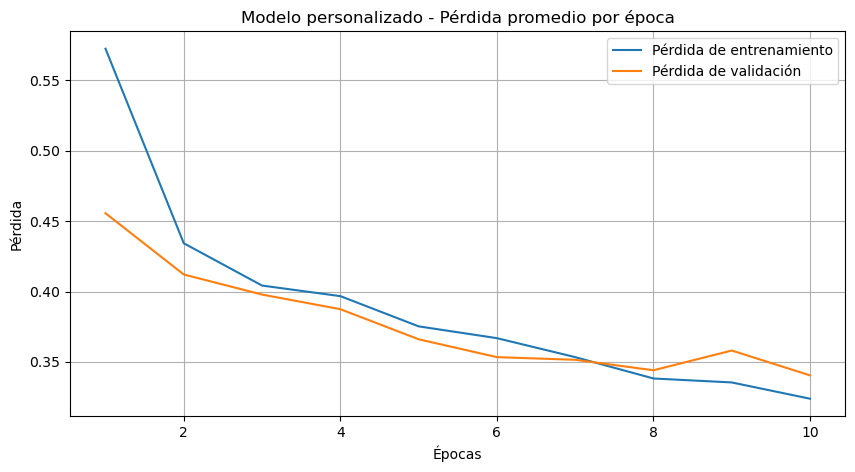

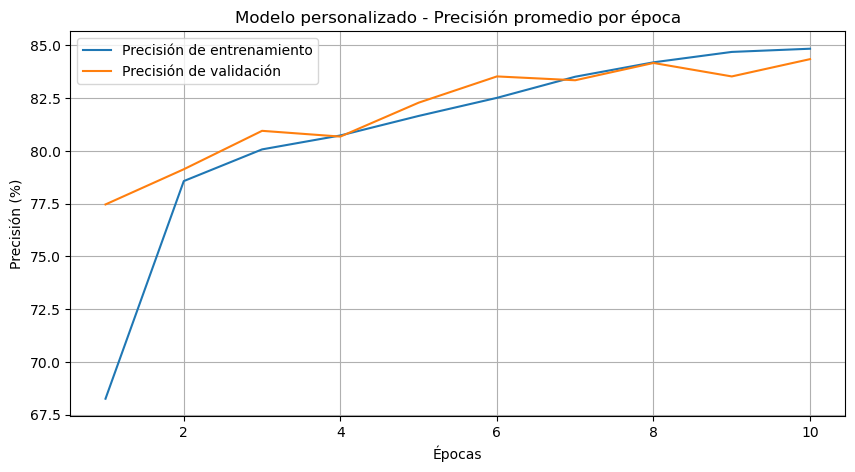

In [109]:
# División inicial en conjunto de entrenamiento y prueba
test_size = 0.2  # 20% del dataset será para pruebas
train_indices, test_indices = train_test_split(
    list(range(len(dataset_norm))),
    test_size=test_size,
    stratify=[label for _, label in dataset_norm],  # Asegura distribución estratificada
    random_state=42
)

# Crear subconjuntos de entrenamiento y prueba
train_dataset = Subset(dataset_norm, train_indices)
test_dataset = Subset(dataset_norm, test_indices)

# Configuración para k-fold cross-validation
k_folds = 5
epochs = 10

# Inicializar almacenamiento de métricas promedio
train_loss_means = np.zeros(epochs)
val_loss_means = np.zeros(epochs)
train_accuracy_means = np.zeros(epochs)
val_accuracy_means = np.zeros(epochs)

# StratifiedKFold: Divide el conjunto de datos manteniendo la distribución de clases
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Convertir el dataset en listas de índices
dataset_len = len(dataset_norm)
indices = list(range(dataset_len))
labels = [label for _, label in dataset_norm]

# Ciclo sobre los pliegues
for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print(f"\nEntrenando fold {fold+1}/{k_folds}...")

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset_norm, train_idx)
    val_subset = Subset(dataset_norm, val_idx)

    # Crear DataLoader para test
    train_loader = DataLoader(
        train_subset, batch_size=32, shuffle=True,
        collate_fn=lambda x: (torch.stack([item[0] for item in x]), 
                              torch.tensor([item[1] for item in x]).squeeze())
    )

    # Crear DataLoader para test
    val_loader = DataLoader(
        val_subset, batch_size=1000, shuffle=False,
        collate_fn=lambda x: (torch.stack([item[0] for item in x]), 
                              torch.tensor([item[1] for item in x]).squeeze())
    )

    # Inicializar modelo, optimizador y función de pérdida por cada fold
    model = CNN()  # Cambia a LeNet o AlexNet si es necesario
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss_function = nn.BCELoss()

    # Entrenar y evaluar el modelo en el pliegue actual
    results = train_and_evaluate(model, optimizer, loss_function, train_loader, val_loader, epochs)
    
    # Extraer métricas por pliegue
    train_losses = np.array(results[2])  # Pérdida de entrenamiento por época
    val_losses = np.array(results[3])    # Pérdida de validación por época
    train_accuracies = np.array(results[0])  # Precisión de entrenamiento por época
    val_accuracies = np.array(results[1])    # Precisión de validación por época

    #Mostrar resumen del entrenamiento
    print("\nResumen del entrenamiento:")

    summary_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Accuracy Train (%)': results[0],
        'Accuracy Test (%)': results[1],
        'Loss Train': results[2],
        'Loss Test': results[3]
    })
    
    print(summary_df)
    print(f"Accuracy final: {results[1][-1]:.2f}%")
    print(f"Tiempo de ejecución: {results[6]:.2f} segundos")

    # Acumular métricas para promediar al final
    train_loss_means += train_losses
    val_loss_means += val_losses
    train_accuracy_means += train_accuracies
    val_accuracy_means += val_accuracies

# Promediar métricas entre los pliegues
train_loss_means /= k_folds
val_loss_means /= k_folds
train_accuracy_means /= k_folds
val_accuracy_means /= k_folds

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_means, label="Pérdida de entrenamiento")
plt.plot(range(1, epochs + 1), val_loss_means, label="Pérdida de validación")
plt.title("Modelo personalizado - Pérdida promedio por época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid()
plt.show()

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy_means, label="Precisión de entrenamiento")
plt.plot(range(1, epochs + 1), val_accuracy_means, label="Precisión de validación")
plt.title("Modelo personalizado - Precisión promedio por época")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.legend()
plt.grid()
plt.show()


Entrenando el modelo con todo el conjunto de datos de entrenamiento...
Entrenamiento finalizado en un periodo de 583.71 segundos.

Modelo entrenado guardado como 'model.pth'.

Evaluando el modelo en el conjunto de test...

Resultados del conjunto de test:
Loss: 0.3632
Accuracy: 83.33%


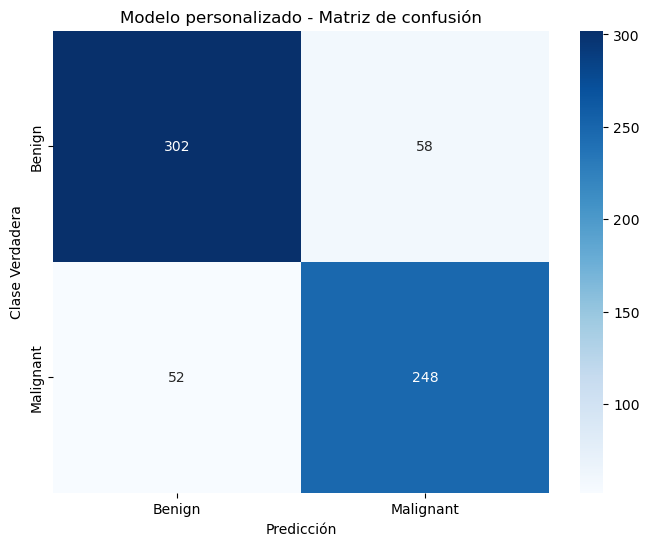

In [32]:
# Entrenamiento del modelo con el conjunto de datos completo
print("\nEntrenando el modelo con todo el conjunto de datos de entrenamiento...")

# Crear DataLoader para el conjunto completo de datos
final_train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    collate_fn=lambda x: (
        torch.stack([item[0] for item in x]), 
        torch.tensor([item[1] for item in x]).squeeze()
    )
)

# Inicializar el modelo, optimizador y función de pérdida
final_model = CNN()  # Cambiar a LeNet o AlexNet si es necesario
final_optimizer = optim.Adam(final_model.parameters(), lr=0.0001)
final_loss_function = nn.BCELoss()

# Configuración de entrenamiento
final_epochs = 10  # Número de épocas para el entrenamiento final

# Entrenamiento en el conjunto completo
start_time = time.time()
for epoch in range(final_epochs):
    train_loss, train_accuracy, trained_model = train(
        final_model, final_train_loader, final_optimizer, final_loss_function, epoch
    )

# Finalización del entrenamiento
training_time = time.time() - start_time
print(f"Entrenamiento finalizado en un periodo de {training_time:.2f} segundos.")
torch.save(trained_model.state_dict(), 'model.pth')
print("\nModelo entrenado guardado como 'model.pth'.")

# Prueba del modelo con el conjunto de test
print("\nEvaluando el modelo en el conjunto de test...")

# Crear DataLoader para test
test_loader = DataLoader(
    test_dataset, batch_size=1000, shuffle=False,
    collate_fn=lambda x: (torch.stack([item[0] for item in x]), 
                          torch.tensor([item[1] for item in x]).squeeze())
)

# Evaluar el modelo entrenado
test_loss, test_accuracy, test_preds, test_labels = test(final_model, test_loader, loss_function)

# Resultados finales
print("\nResultados del conjunto de test:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(test_labels, test_preds)

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title("Modelo personalizado - Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Clase Verdadera")
plt.show()

## Modelo Le Net


Entrenando fold 1/5...
Epoch 1: Train Loss = 0.6017, Train Accuracy = 63.22%, Test Loss = 0.4954, Test Accuracy = 76.82%
Epoch 2: Train Loss = 0.5094, Train Accuracy = 73.11%, Test Loss = 0.4905, Test Accuracy = 73.03%
Epoch 3: Train Loss = 0.4526, Train Accuracy = 77.21%, Test Loss = 0.4091, Test Accuracy = 81.67%
Epoch 4: Train Loss = 0.4235, Train Accuracy = 78.65%, Test Loss = 0.3880, Test Accuracy = 80.91%
Epoch 5: Train Loss = 0.4044, Train Accuracy = 79.41%, Test Loss = 0.3995, Test Accuracy = 79.09%
Epoch 6: Train Loss = 0.3960, Train Accuracy = 81.08%, Test Loss = 0.3795, Test Accuracy = 80.61%
Epoch 7: Train Loss = 0.3781, Train Accuracy = 81.38%, Test Loss = 0.3889, Test Accuracy = 80.15%
Epoch 8: Train Loss = 0.3710, Train Accuracy = 82.52%, Test Loss = 0.3649, Test Accuracy = 82.42%
Epoch 9: Train Loss = 0.3608, Train Accuracy = 82.48%, Test Loss = 0.3597, Test Accuracy = 82.42%
Epoch 10: Train Loss = 0.3554, Train Accuracy = 82.14%, Test Loss = 0.3560, Test Accuracy = 83

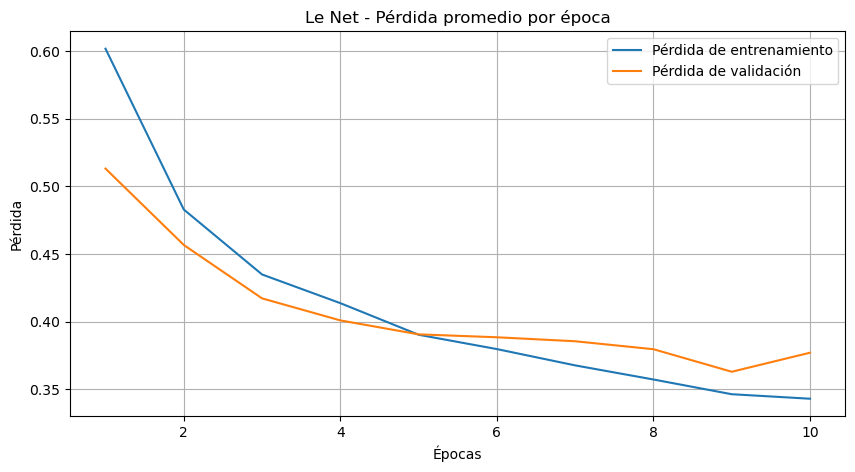

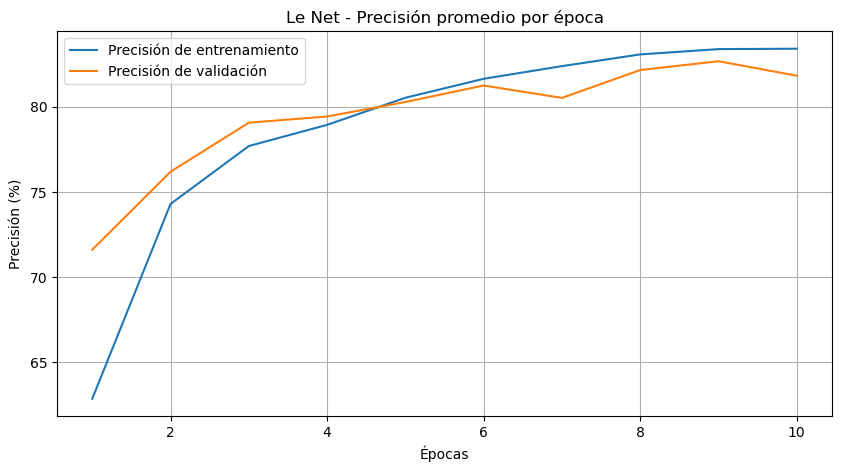

In [34]:
# División inicial en conjunto de entrenamiento y prueba
test_size = 0.2  # 20% del dataset será para pruebas
train_indices, test_indices = train_test_split(
    list(range(len(dataset_norm))),
    test_size=test_size,
    stratify=[label for _, label in dataset_norm],  # Asegura distribución estratificada
    random_state=42
)

# Crear subconjuntos de entrenamiento y prueba
train_dataset = Subset(dataset_norm, train_indices)
test_dataset = Subset(dataset_norm, test_indices)

# Configuración para k-fold cross-validation
k_folds = 5
epochs = 10

# Inicializar almacenamiento de métricas promedio
train_loss_means = np.zeros(epochs)
val_loss_means = np.zeros(epochs)
train_accuracy_means = np.zeros(epochs)
val_accuracy_means = np.zeros(epochs)

# StratifiedKFold: Divide el conjunto de datos manteniendo la distribución de clases
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Convertir el dataset en listas de índices
dataset_len = len(dataset_norm)
indices = list(range(dataset_len))
labels = [label for _, label in dataset_norm]

# Ciclo sobre los pliegues
for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print(f"\nEntrenando fold {fold+1}/{k_folds}...")

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset_norm, train_idx)
    val_subset = Subset(dataset_norm, val_idx)

    # Crear DataLoader para test
    train_loader = DataLoader(
        train_subset, batch_size=32, shuffle=True,
        collate_fn=lambda x: (torch.stack([item[0] for item in x]), 
                              torch.tensor([item[1] for item in x]).squeeze())
    )

    # Crear DataLoader para test
    val_loader = DataLoader(
        val_subset, batch_size=1000, shuffle=False,
        collate_fn=lambda x: (torch.stack([item[0] for item in x]), 
                              torch.tensor([item[1] for item in x]).squeeze())
    )

    # Inicializar modelo, optimizador y función de pérdida por cada fold
    lenet_model = LeNet()  
    lenet_optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)
    loss_function = nn.BCELoss()

    # Entrenar y evaluar el modelo en el pliegue actual
    results = train_and_evaluate(lenet_model, lenet_optimizer, loss_function, train_loader, val_loader, epochs)
    
    # Extraer métricas por pliegue
    train_losses = np.array(results[2])  # Pérdida de entrenamiento por época
    val_losses = np.array(results[3])    # Pérdida de validación por época
    train_accuracies = np.array(results[0])  # Precisión de entrenamiento por época
    val_accuracies = np.array(results[1])    # Precisión de validación por época

    #Mostrar resumen del entrenamiento
    print("\nResumen del entrenamiento:")

    summary_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Accuracy Train (%)': results[0],
        'Accuracy Test (%)': results[1],
        'Loss Train': results[2],
        'Loss Test': results[3]
    })
    
    print(summary_df)
    print(f"Accuracy final: {results[1][-1]:.2f}%")
    print(f"Tiempo de ejecución: {results[6]:.2f} segundos")

    # Acumular métricas para promediar al final
    train_loss_means += train_losses
    val_loss_means += val_losses
    train_accuracy_means += train_accuracies
    val_accuracy_means += val_accuracies

# Promediar métricas entre los pliegues
train_loss_means /= k_folds
val_loss_means /= k_folds
train_accuracy_means /= k_folds
val_accuracy_means /= k_folds

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_means, label="Pérdida de entrenamiento")
plt.plot(range(1, epochs + 1), val_loss_means, label="Pérdida de validación")
plt.title("Le Net - Pérdida promedio por época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid()
plt.show()

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy_means, label="Precisión de entrenamiento")
plt.plot(range(1, epochs + 1), val_accuracy_means, label="Precisión de validación")
plt.title("Le Net - Precisión promedio por época")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.legend()
plt.grid()
plt.show()


Entrenando el modelo con todo el conjunto de datos de entrenamiento...
Entrenamiento finalizado en un periodo de 286.80 segundos.

Modelo entrenado guardado como 'final_model.pth'.

Evaluando el modelo en el conjunto de test...

Resultados del conjunto de test:
Loss: 0.4292
Accuracy: 80.30%


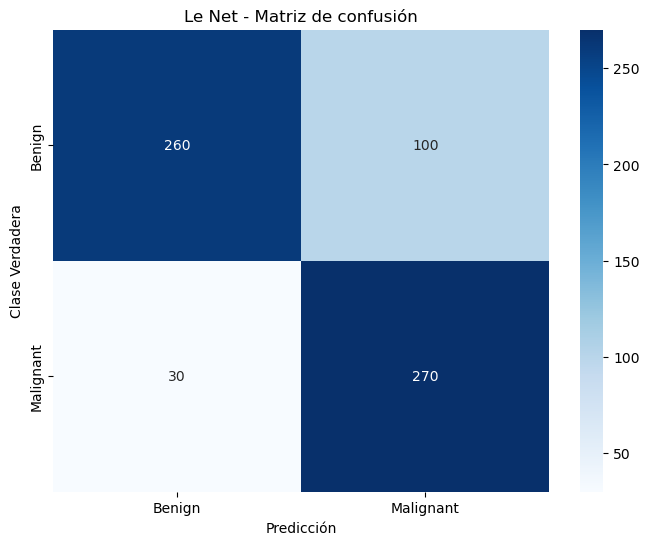

In [59]:
# Entrenamiento del modelo con el conjunto de datos completo
print("\nEntrenando el modelo con todo el conjunto de datos de entrenamiento...")

# Crear DataLoader para el conjunto completo de datos
lenet_final_train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    collate_fn=lambda x: (
        torch.stack([item[0] for item in x]), 
        torch.tensor([item[1] for item in x]).squeeze()
    )
)

# Inicializar el modelo, optimizador y función de pérdida
lenet_final_model = LeNet()  # Cambiar a LeNet o AlexNet si es necesario
lenet_final_optimizer = optim.Adam(lenet_final_model.parameters(), lr=0.001)
lenet_final_loss_function = nn.BCELoss()

# Configuración de entrenamiento
final_epochs = 9  # Número de épocas para el entrenamiento final

# Entrenamiento en el conjunto completo
start_time = time.time()
for epoch in range(final_epochs):
    train_loss, train_accuracy, lenet_trained_model = train(
        lenet_final_model, lenet_final_train_loader, lenet_final_optimizer, lenet_final_loss_function, epoch
    )

# Finalización del entrenamiento
training_time = time.time() - start_time
print(f"Entrenamiento finalizado en un periodo de {training_time:.2f} segundos.")
#torch.save(trained_model.state_dict(), 'final_model.pth')
print("\nModelo entrenado guardado como 'final_model.pth'.")

# Prueba del modelo con el conjunto de test
print("\nEvaluando el modelo en el conjunto de test...")

# Crear DataLoader para test
test_loader = DataLoader(
    test_dataset, batch_size=1000, shuffle=False,
    collate_fn=lambda x: (torch.stack([item[0] for item in x]), 
                          torch.tensor([item[1] for item in x]).squeeze())
)

# Evaluar el modelo entrenado
test_loss, test_accuracy, test_preds, test_labels = test(lenet_final_model, test_loader, loss_function)

# Resultados finales
print("\nResultados del conjunto de test:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(test_labels, test_preds)

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title("Le Net - Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Clase Verdadera")
plt.show()

---

## Modelo AlexNet 


Entrenando fold 1/5...
Epoch 1: Train Loss = 0.3703, Train Accuracy = 82.71%, Test Loss = 0.3240, Test Accuracy = 84.09%
Epoch 2: Train Loss = 0.2400, Train Accuracy = 89.84%, Test Loss = 0.3403, Test Accuracy = 84.39%
Epoch 3: Train Loss = 0.1792, Train Accuracy = 92.30%, Test Loss = 0.3547, Test Accuracy = 85.76%
Epoch 4: Train Loss = 0.1223, Train Accuracy = 94.46%, Test Loss = 0.3139, Test Accuracy = 85.91%
Epoch 5: Train Loss = 0.1094, Train Accuracy = 95.83%, Test Loss = 0.3673, Test Accuracy = 87.88%
Epoch 6: Train Loss = 0.0754, Train Accuracy = 97.04%, Test Loss = 0.4275, Test Accuracy = 88.18%
Epoch 7: Train Loss = 0.0408, Train Accuracy = 98.29%, Test Loss = 0.5728, Test Accuracy = 87.58%
Epoch 8: Train Loss = 0.0272, Train Accuracy = 99.20%, Test Loss = 0.9041, Test Accuracy = 88.48%
Epoch 9: Train Loss = 0.0748, Train Accuracy = 97.54%, Test Loss = 0.4446, Test Accuracy = 88.48%
Epoch 10: Train Loss = 0.0415, Train Accuracy = 98.45%, Test Loss = 0.4533, Test Accuracy = 86

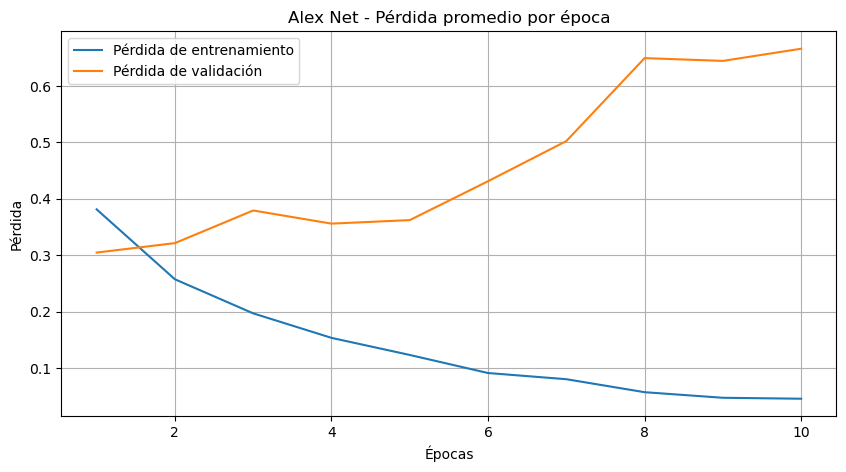

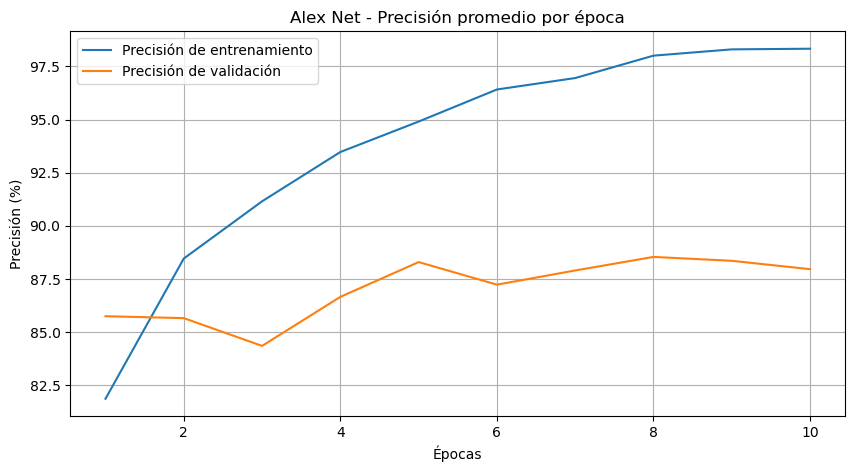

In [158]:
# División inicial en conjunto de entrenamiento y prueba
test_size = 0.2  # 20% del dataset será para pruebas
train_indices, test_indices = train_test_split(
    list(range(len(dataset_norm))),
    test_size=test_size,
    stratify=[label for _, label in dataset_norm],  # Asegura distribución estratificada
    random_state=42
)

# Crear subconjuntos de entrenamiento y prueba
train_dataset = Subset(dataset_norm, train_indices)
test_dataset = Subset(dataset_norm, test_indices)

# Configuración para k-fold cross-validation
k_folds = 5
epochs = 10

# Inicializar almacenamiento de métricas promedio
train_loss_means = np.zeros(epochs)
val_loss_means = np.zeros(epochs)
train_accuracy_means = np.zeros(epochs)
val_accuracy_means = np.zeros(epochs)

# StratifiedKFold: Divide el conjunto de datos manteniendo la distribución de clases
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Convertir el dataset en listas de índices
dataset_len = len(dataset_norm)
indices = list(range(dataset_len))
labels = [label for _, label in dataset_norm]

# Ciclo sobre los pliegues
for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print(f"\nEntrenando fold {fold+1}/{k_folds}...")

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset_norm, train_idx)
    val_subset = Subset(dataset_norm, val_idx)

    # Crear DataLoader para test
    train_loader = DataLoader(
        train_subset, batch_size=32, shuffle=True,
        collate_fn=lambda x: (torch.stack([item[0] for item in x]), 
                              torch.tensor([item[1] for item in x]).squeeze())
    )

    # Crear DataLoader para test
    val_loader = DataLoader(
        val_subset, batch_size=1000, shuffle=False,
        collate_fn=lambda x: (torch.stack([item[0] for item in x]), 
                              torch.tensor([item[1] for item in x]).squeeze())
    )

    # Inicializar modelo, optimizador y función de pérdida por cada fold
    alexnet_model = AlexNet()  
    alexnet_optimizer = optim.Adam(alexnet_model.parameters(), lr=0.0001)
    loss_function = nn.BCELoss()

    # Entrenar y evaluar el modelo en el pliegue actual
    results = train_and_evaluate(alexnet_model, alexnet_optimizer, loss_function, train_loader, val_loader, epochs)
    
    # Extraer métricas por pliegue
    train_losses = np.array(results[2])  # Pérdida de entrenamiento por época
    val_losses = np.array(results[3])    # Pérdida de validación por época
    train_accuracies = np.array(results[0])  # Precisión de entrenamiento por época
    val_accuracies = np.array(results[1])    # Precisión de validación por época

    #Mostrar resumen del entrenamiento
    print("\nResumen del entrenamiento:")

    summary_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Accuracy Train (%)': results[0],
        'Accuracy Test (%)': results[1],
        'Loss Train': results[2],
        'Loss Test': results[3]
    })
    
    print(summary_df)
    print(f"Accuracy final: {results[1][-1]:.2f}%")
    print(f"Tiempo de ejecución: {results[6]:.2f} segundos")

    # Acumular métricas para promediar al final
    train_loss_means += train_losses
    val_loss_means += val_losses
    train_accuracy_means += train_accuracies
    val_accuracy_means += val_accuracies

# Promediar métricas entre los pliegues
train_loss_means /= k_folds
val_loss_means /= k_folds
train_accuracy_means /= k_folds
val_accuracy_means /= k_folds

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_means, label="Pérdida de entrenamiento")
plt.plot(range(1, epochs + 1), val_loss_means, label="Pérdida de validación")
plt.title("Alex Net - Pérdida promedio por época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid()
plt.show()

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy_means, label="Precisión de entrenamiento")
plt.plot(range(1, epochs + 1), val_accuracy_means, label="Precisión de validación")
plt.title("Alex Net - Precisión promedio por época")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.legend()
plt.grid()
plt.show()


Entrenando el modelo con todo el conjunto de datos de entrenamiento...
Entrenamiento finalizado en un periodo de 23.56 segundos.

Modelo entrenado guardado como 'alexnet_model.pth'.

Evaluando el modelo en el conjunto de test...

Resultados del conjunto de test:
Loss: 0.4747
Accuracy: 77.58%


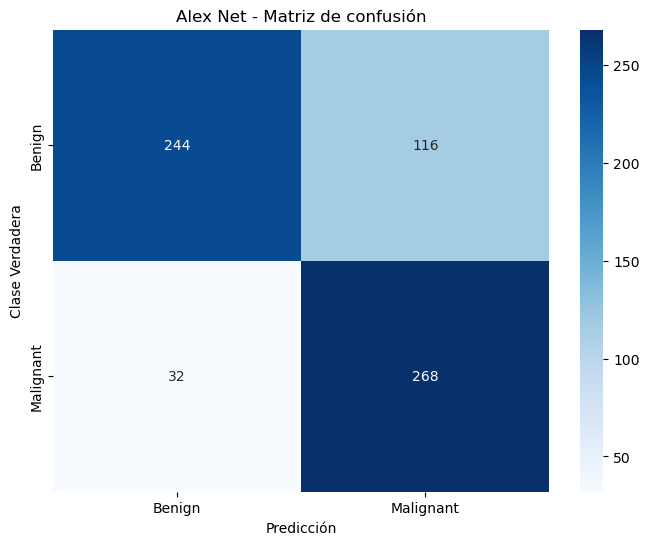

In [178]:
# Entrenamiento del modelo con el conjunto de datos completo
print("\nEntrenando el modelo con todo el conjunto de datos de entrenamiento...")

# Crear DataLoader para el conjunto completo de datos
alexnet_final_train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    collate_fn=lambda x: (
        torch.stack([item[0] for item in x]), 
        torch.tensor([item[1] for item in x]).squeeze()
    )
)

# Inicializar el modelo, optimizador y función de pérdida
alexnet_final_model = LeNet()  # Cambiar a LeNet o AlexNet si es necesario
alexnet_final_optimizer = optim.Adam(alexnet_final_model.parameters(), lr=0.001)
alexnet_final_loss_function = nn.BCELoss()

# Configuración de entrenamiento
final_epochs = 2  # Número de épocas para el entrenamiento final

# Entrenamiento en el conjunto completo
start_time = time.time()
for epoch in range(final_epochs):
    train_loss, train_accuracy, alexnet_trained_model = train(
        alexnet_final_model, alexnet_final_train_loader, alexnet_final_optimizer, alexnet_final_loss_function, epoch
    )

# Finalización del entrenamiento
training_time = time.time() - start_time
print(f"Entrenamiento finalizado en un periodo de {training_time:.2f} segundos.")
#torch.save(trained_model.state_dict(), 'alexnet_model.pth')
print("\nModelo entrenado guardado como 'alexnet_model.pth'.")

# Prueba del modelo con el conjunto de test
print("\nEvaluando el modelo en el conjunto de test...")

# Crear DataLoader para test
test_loader = DataLoader(
    test_dataset, batch_size=1000, shuffle=False,
    collate_fn=lambda x: (torch.stack([item[0] for item in x]), 
                          torch.tensor([item[1] for item in x]).squeeze())
)

# Evaluar el modelo entrenado
test_loss, test_accuracy, test_preds, test_labels = test(alexnet_final_model, test_loader, loss_function)

# Resultados finales
print("\nResultados del conjunto de test:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(test_labels, test_preds)

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title("Alex Net - Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Clase Verdadera")
plt.show()

## Modelo de explicabilidad LIME

#### Configuración inicial

Este código configura y adapta la arquitectura AlexNet para un problema de clasificación binaria, cargando pesos preentrenados desde un archivo externo y estableciendo el modelo en modo evaluación. A continuación, se detallan los pasos:

1. **Inicialización de semillas**: 
   - Se utiliza `np.random.seed(222)` para fijar la semilla de NumPy y `torch.manual_seed(222)` para la de PyTorch. Esto garantiza que los cálculos aleatorios (como la inicialización de pesos) sean reproducibles en cada ejecución del código.

2. **Carga de la arquitectura AlexNet**: 
   - `models.alexnet(pretrained=False)` carga la estructura básica de AlexNet sin incluir pesos preentrenados. Este modelo será modificado y adaptado para el problema específico.

3. **Modificación de la última capa**: 
   - La capa final del clasificador de AlexNet (`classifier[6]`) se reemplaza con una capa lineal que tiene:
     - `in_features=4096`: el número de características que recibe de la capa anterior.
     - `out_features=1`: genera una salida escalar para realizar clasificación binaria. Esto es útil en combinación con una función sigmoide para obtener probabilidades.

4. **Carga de pesos preentrenados**:
   - Los pesos del modelo se cargan desde un archivo externo usando `torch.load()`.
   - Las claves del diccionario de pesos (`state_dict`) se ajustan eliminando un prefijo (`alexnet.`) para que coincidan con las claves del modelo actual.
   - `alexnet_model.load_state_dict(state_dict, strict=False)` carga los pesos ajustados en el modelo. El parámetro `strict=False` permite flexibilidad en la correspondencia entre las claves del diccionario de pesos y el modelo.

5. **Modo de evaluación**: 
   - Finalmente, se establece el modelo en modo evaluación (`alexnet_model.eval()`). En este modo, ciertas capas como Dropout y Batch Normalization funcionan de manera diferente, lo que es adecuado para realizar predicciones en lugar de en.
cciones.

---

---


In [ ]:
# Configuración
np.random.seed(222)
torch.manual_seed(222)

# Cargar el modelo AlexNet preentrenado
# Cargar la arquitectura de AlexNet sin pesos preentrenados
alexnet_model = models.alexnet(pretrained=False)

# Modificar la última capa de clasificación para que tenga 2 clases
alexnet_model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=1)

# Cargar los pesos desde el archivo .pth
state_dict = torch.load(r'C:\Users\Usuario\Downloads\alexnet_model.pth')

# Ajustar las claves del state_dict (eliminar el prefijo "alexnet." de las claves)
state_dict = {k.replace('alexnet.', ''): v for k, v in state_dict.items()}

# Cargar los pesos ajustados en el modelo
alexnet_model.load_state_dict(state_dict, strict=False)

# Establecer el modelo en modo de evaluación
alexnet_model.eval()

### Transformación y carga de la imagen

A continuación, se prepara una imagen para ser procesada por el modelo AlexNet. Se detallan los pasos realizados:

1. **Definición de las transformaciones**:
   - Se utiliza `transforms.Compose()` para encadenar varias transformaciones necesarias:
     - `transforms.ToPILImage()`: Convierte la imagen a un formato compatible con PIL.
     - `transforms.Resize((224, 224))`: Ajusta la imagen a un tamaño de 224x224 píxeles, que es el tamaño de entrada requerido por AlexNet.
     - `transforms.ToTensor()`: Convierte la imagen a un tensor de PyTorch, normalizando los valores de píxeles al rango [0, 1].
     - `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normaliza los valores de los canales RGB según las medias y desviaciones estándar usadas en modelos preentrenados con ImageNet.

2. **Carga de la imagen**:
   - Se utiliza `skimage.io.imread()` para cargar una imagen desde una ruta específica. En este caso, la imagen pertenece a la clase `malignant`.

3. **Redimensionamiento de la imagen**:
   - `skimage.transform.resize()` se usa para redimensionar la imagen a 224x224 píxeles, asegurando que el tamaño sea compatible con las dimensiones requeridas por el modelo.

4. **Conversión a tensor**:
   - La imagen redimensionada se transforma aplicando las operaciones definidas anteriormente con `transform`, lo que incluye normalización y conversión a tensor.
   - `unsqueeze(0)` agrega una dimensión adicional para representar el batch size, necesario para procesar la imagen a través del modelo.

5. **Visualización de la imagen**:
   - `plt.imshow()` muestra la imagen redimensionada en pantalla, proporcionando una vista previa del dato que se procesará. El título de la figura se establece como "Imagen Original" usando `plt.title()`.

Este flujo asegura que la imagen se prepare correctamente antes de ser pasada al modelo AlexNet para predicción.

In [ ]:
# Transformación de la imagen para el modelo
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Ajustar la imagen a 224x224 para AlexNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de imagen
])

# Cargar la imagen
Xi = skimage.io.imread(r'C:\Users\Usuario\Desktop\Trabajo Fin de Grado\skin_cancer\malignant\0004.jpg')
Xi_resized = skimage.transform.resize(Xi, (224, 224))  # Redimensionar la imagen
Xi_tensor = transform(Xi_resized).unsqueeze(0)  # Convertir a tensor y agregar dimensión batch

# Mostrar la imagen original
plt.imshow(Xi_resized)
plt.title("Imagen Original")
plt.show()

#### Predicción del modelo 

1. **Definición de la función `predict_single_image`**:
   - Esta función toma como entrada un modelo y un tensor de imagen preparado (como el `Xi_tensor` generado en el bloque anterior).
   - El proceso se realiza con las siguientes etapas:
     - `model.eval()`: Configura el modelo en modo de evaluación, lo cual desactiva operaciones específicas del entrenamiento como Dropout.
     - `torch.no_grad()`: Desactiva el cálculo de gradientes, optimizando el uso de memoria y reduciendo el tiempo de computación durante la inferencia.
     - `model(image_tensor)`: Realiza una pasada hacia adelante (forward pass) de la imagen a través del modelo, obteniendo el resultado bruto (`output`).
     - `torch.sigmoid(output)`: Aplica la función sigmoide al resultado bruto para convertirlo en una probabilidad en el rango [0, 1].
     - `(pred > 0.5).float()`: Determina la clase predicha aplicando un umbral de 0.5. Si la probabilidad es mayor a 0.5, se asigna la clase 1; de lo contrario, la clase 0.

2. **Realización de la predicción**:
   - Se llama a la función `predict_single_image` con el modelo `alexnet_model` y la imagen `Xi_tensor` como argumentos.
   - La función devuelve:
     - `predicted_class`: Clase binaria predicha (0 para benigno, 1 para maligno).
     - `prediction_prob`: Probabilidad asignada por el modelo a la clase predicha.

3. **Interpretación de la clase predicha**:
   - Si la clase predicha es `0.0`, se interpreta como "Benign".
   - Si la clase predicha es `1.0`, se interpreta como "Malign".
   - Se utiliza una estructura condicional (`if-else`) para determinar la interpretación textual de la clase.

4. **Visualización del resultado**:
   - `print()` muestra en consola:
     - La clase predicha (numérica y textual).
     - La probabilidad asignada por el modelo a la clase predicha.

In [ ]:
# Realizar predicciones
def predict_single_image(model, image_tensor):
    model.eval()  # Poner el modelo en modo evaluación
    with torch.no_grad():  # Desactivar el cálculo de gradientes para la predicción
        output = model(image_tensor)  # Pasar la imagen a través del modelo
        pred = torch.sigmoid(output)  # Aplicar la función sigmoide para obtener probabilidades
        predicted_class = (pred > 0.5).float()  # Convertir la predicción en clase binaria
    return predicted_class, pred.item()

# Llamada a la función para realizar la predicción
predicted_class, prediction_prob = predict_single_image(alexnet_model, Xi_tensor)
if predicted_class == 0.0:
    clase = "Benign"
else:
    clase = "Malign"
print(f"Clase Predicha: {predicted_class.item()} ({clase})")
print(f"Probabilidad Predicha: {prediction_prob}")

#### Segmentación en superpíxeles

1. **Segmentación con Quickshift**:
   - La segmentación de superpíxeles se realiza utilizando el algoritmo *Quickshift*, proporcionado por `skimage.segmentation.quickshift`.
   - Parámetros utilizados:
     - `Xi_resized`: Imagen redimensionada previamente para que tenga dimensiones (224, 224).
     - `kernel_size=4`: Tamaño del núcleo de la ventana de análisis. Este valor controla el alcance espacial de las agrupaciones locales.
     - `max_dist=200`: Distancia máxima permitida entre píxeles para ser considerados dentro del mismo superpíxel.
     - `ratio=0.2`: Peso relativo de la similitud de color frente a la proximidad espacial. Un valor menor favorece la agrupación basada en colores similares.

   - El resultado, `superpixels`, es una matriz donde cada píxel está asignado a un superpíxel específico. Los valores en esta matriz indican la etiqueta del superpíxel al que pertenece cada píxel.

2. **Cálculo del número de superpíxeles**:
   - `np.unique(superpixels).shape[0]` obtiene el número total de superpíxeles únicos presentes en la segmentación.
   - El número de superpíxeles se imprime en consola con `print()`.

3. **Visualización de la segmentación**:
   - Se utiliza `skimage.segmentation.mark_boundaries` para superponer las fronteras de los superpíxeles sobre la imagen original (`Xi_resized`).
   - `skimage.io.imshow` muestra la imagen segmentada, destacando las áreas identificadas como superpíxeles.

In [ ]:
# Segmentación de superpixeles
superpixels = skimage.segmentation.quickshift(Xi_resized, kernel_size=4, max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
print(f"Superpixeles: {num_superpixels}")

# Mostrar imagen segmentada
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi_resized, superpixels))
plt.show()

#### Generar perturbaciones y calcular predicciones

1. **Generación de perturbaciones binarias**:
   - Se genera un conjunto de perturbaciones binarias utilizando `np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))`.
     - `1` indica que se generarán valores binarios (0 o 1).
     - `0.5` es la probabilidad de que un valor sea 1 (lo que implica que cada superpíxel tiene un 50% de probabilidad de ser activado).
     - `num_perturb` es el número de perturbaciones a generar.
     - `num_superpixels` es el número total de superpíxeles en la imagen.

   Esto da como resultado una matriz `perturbations`, en la que cada fila representa una perturbación (un conjunto de superpíxeles activados/desactivados).

2. **Función para perturbar la imagen**:
   - La función `perturb_image` toma tres parámetros:
     - `img`: La imagen original.
     - `perturbation`: Un vector binario que indica qué superpíxeles deben activarse.
     - `segments`: La segmentación de superpíxeles de la imagen.
   - Dentro de la función:
     - Se crea una máscara `mask` donde los valores activos de la perturbación (1s) se marcan en los superpíxeles correspondientes.
     - Se aplica esta máscara sobre la imagen original para "perturbar" solo los superpíxeles seleccionados.

3. **Realización de predicciones sobre las imágenes perturbadas**:
   - Para cada perturbación en `perturbations`, se genera una imagen perturbada utilizando la función `perturb_image`.
   - La imagen perturbada se convierte en tensor usando `transform` y se le agrega una dimensión de batch.
   - Se realiza una predicción sobre esta imagen utilizando el modelo `alexnet_model` en modo evaluación (`model.eval()` y `torch.no_grad()`).
   - La predicción se almacena en la lista `predictions`.

4. **Consolidación de las predicciones**:
   - Las predicciones individuales se apilan en un solo tensor `predictions` utilizando `torch.stack()`.
   - Finalmente, se imprime la forma del tensor `predictions`, que contiene las salidas del modelo para cada perturbación.

In [ ]:
# Generar perturbaciones binarias
num_perturb = 100
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

# Perturbar la imagen
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:,:,np.newaxis]
    return perturbed_image

# Realizar predicciones sobre las perturbaciones
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi_resized, pert, superpixels)
    perturbed_tensor = transform(perturbed_img).unsqueeze(0)  # Convertir a tensor
    with torch.no_grad():
        pred = alexnet_model(perturbed_tensor)
    predictions.append(pred)

predictions = torch.stack(predictions)
print(predictions.shape)

#### Explicación con LIME

1. **Cálculo de distancias de similitud**:
   - Se crea un vector `original_image` que representa la perturbación con todos los superpíxeles activados, es decir, una imagen de referencia donde todos los superpíxeles están "encendidos".
   - Luego, se calculan las distancias de similitud entre las perturbaciones generadas previamente (`perturbations`) y esta imagen de referencia utilizando la métrica de distancia coseno (`cosine`).
     - `sklearn.metrics.pairwise_distances()` calcula la distancia entre cada fila de `perturbations` y `original_image`.
   - Las distancias se aplana con `.ravel()` para que sea un vector unidimensional.

2. **Cálculo de pesos**:
   - Se define `kernel_width` como 0.25. Este parámetro se utiliza para ajustar la forma de la función de kernel, que determina la importancia de cada perturbación según su distancia a la imagen original.
   - La función de kernel se calcula utilizando una fórmula de Gaussiana. Los pesos se obtienen con la fórmula: 
     \[
     \text{weights} = \sqrt{\exp\left(-\frac{\text{distances}^2}{\text{kernel_width}^2}\right)}
     \]
   - Los pesos están inversamente relacionados con las distancias: las perturbaciones más cercanas a la imagen original tienen un mayor peso.

3. **Regresión lineal para explicar el modelo**:
   - Se utiliza un modelo de regresión lineal (`LinearRegression()`) para ajustar una relación entre las perturbaciones y las predicciones del modelo original. 
   - El modelo se entrena con las perturbaciones como variables independientes (`X=perturbations`), las predicciones del modelo como la variable dependiente (`y=predictions[:, 0].numpy()`), y los pesos calculados previamente (`sample_weight=weights`).
   - Una vez ajustado el modelo, se obtienen los coeficientes del modelo de regresión (`simpler_model.coef_`). Estos coeficientes indican la importancia relativa de cada superpíxel.

4. **Identificación de las características más importantes**:
   - Se seleccionan los superpíxeles más importantes observando los coeficientes del modelo de regresión. Se ordenan los coeficientes y se seleccionan los `num_top_features` más grandes.
   - La variable `top_features` contiene los índices de los superpíxeles más influyentes para la predicción del modelo.

5. **Visualización de los superpíxeles más importantes**:
   - Se crea una máscara (`mask`) en la que solo los superpíxeles más importantes (según los coeficientes) se activan (se les asigna el valor `True`).
   - Luego, se genera una imagen perturbada utilizando solo esos superpíxeles activos. Esta imagen se muestra con `skimage.io.imshow()` para visualizar los superpíxeles más importantes que afectan la predicción.

C:\Users\Usuario\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19260\3451475138.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be

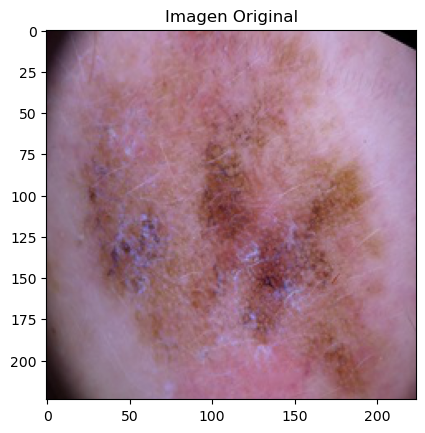

Clase Predicha: 1.0 (Malign)
Probabilidad Predicha: 0.7797372341156006
Superpixeles: 33


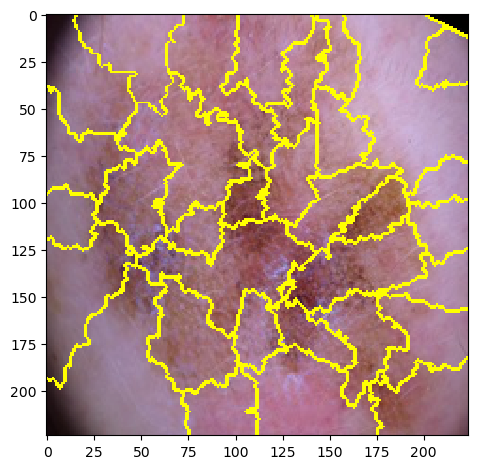

torch.Size([100, 1, 1])
Coeficientes: [-0.04759536  0.06291219  0.10710327  0.02341451 -0.01121699  0.14462438
 -0.13392196  0.05029101 -0.04620117 -0.00461188  0.07126729  0.01907198
 -0.20863166 -0.10514026 -0.02022722  0.01810361 -0.08720223 -0.2397561
  0.0979829  -0.13287774  0.26245601  0.02053     0.14591916  0.01241532
 -0.09116332  0.20783637  0.01248937  0.07303095  0.09909639 -0.20436879
 -0.12485824 -0.11551569 -0.27997502]
Top características: [ 5 22 25 20]


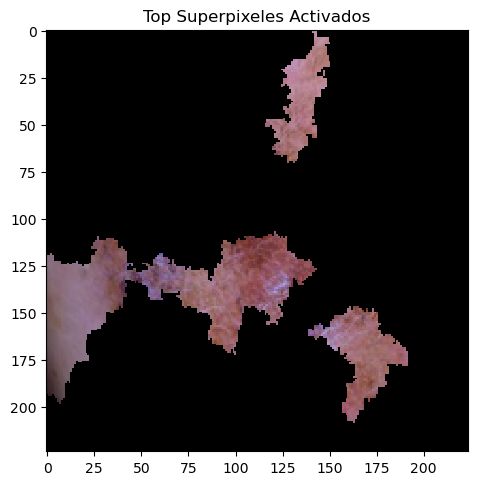

In [127]:
# Calculando distancias de similitud y pesos
original_image = np.ones(num_superpixels)[np.newaxis,:]  # Perturbación con todos los superpixeles activados
distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()

kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))  # Función de kernel

# Modelo simple de regresión lineal para explicar el modelo
class_to_explain = int(predicted_class.item())  # Obtener la clase predicha
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:, 0].numpy(), sample_weight=weights)  # Ajuste del modelo
coeff = simpler_model.coef_[0]
print(f"Coeficientes: {coeff}")

# Mostrar los superpixeles más importantes
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:]
print(f"Top características: {top_features}")

mask = np.zeros(num_superpixels)
mask[top_features] = True  # Activar los superpixeles más importantes
perturbed_img = perturb_image(Xi_resized, mask, superpixels)

# Mostrar la imagen con los superpixeles más importantes activados
skimage.io.imshow(perturbed_img)
plt.title("Top Superpixeles Activados")
plt.show()
